In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [6]:
df = pd.read_csv('df_final_Karachi.csv', delimiter=',' )
df.head()

,time,city,temperature_2m_min,temperature_2m_mean,temperature_2m_max,temp_range,daylight,precipitation_sum,precipitation_hours,precipitation_rate,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2010-01-01,Karachi,14.8,20.9,26.0,11.2,10.633333,0.0,0,0.0,18.3,25.6,16.25,4.38
1,2010-01-02,Karachi,15.6,20.5,25.3,9.7,10.616667,0.0,0,0.0,24.6,35.3,9.15,3.84
2,2010-01-03,Karachi,14.3,19.9,25.0,10.7,10.633333,0.0,0,0.0,16.6,28.1,16.03,3.69
3,2010-01-04,Karachi,15.0,20.4,25.6,10.6,10.650000,0.0,0,0.0,14.0,22.7,16.32,3.63
4,2010-01-05,Karachi,16.3,20.7,25.4,9.1,10.650000,0.0,0,0.0,19.3,29.2,16.37,3.55


In [8]:
train_dates = pd.to_datetime(df['time'])
print(train_dates.tail(15)) #Check last few dates. 

4951   2023-07-23
4952   2023-07-24
4953   2023-07-25
4954   2023-07-26
4955   2023-07-27
4956   2023-07-28
4957   2023-07-29
4958   2023-07-30
4959   2023-07-31
4960   2023-08-01
4961   2023-08-02
4962   2023-08-03
4963   2023-08-04
4964   2023-08-05
4965   2023-08-06
Name: time, dtype: datetime64[ns]


In [12]:
cols = list(df)[2:14]
print(cols)

['temperature_2m_min', 'temperature_2m_mean', 'temperature_2m_max', 'temp_range', 'daylight', 'precipitation_sum', 'precipitation_hours', 'precipitation_rate', 'windspeed_10m_max', 'windgusts_10m_max', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration']


In [13]:
df_for_training = df[cols].astype(float)

In [27]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [28]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [29]:
#In my case, trainX has a shape (4952, 14, 12). 
#Looking back 14 days, 12 features taken into consideration, and v datapoints
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (4952, 1). Our model only predicts a single value.

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (4952, 14, 12).
trainY shape == (4952, 1).


In [30]:
## build lstm 
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            19712     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 32161 (125.63 KB)
Trainable params: 32161 (125.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
279/279 [==============================] - 4s 6ms/step - loss: 0.1257 - val_loss: 0.0652
Epoch 2/5
279/279 [==============================] - 1s 5ms/step - loss: 0.0811 - val_loss: 0.0383
Epoch 3/5
279/279 [==============================] - 1s 5ms/step - loss: 0.0694 - val_loss: 0.0340
Epoch 4/5
279/279 [==============================] - 2s 5ms/step - loss: 0.0648 - val_loss: 0.0353
Epoch 5/5
279/279 [==============================] - 2s 5ms/step - loss: 0.0625 - val_loss: 0.0249


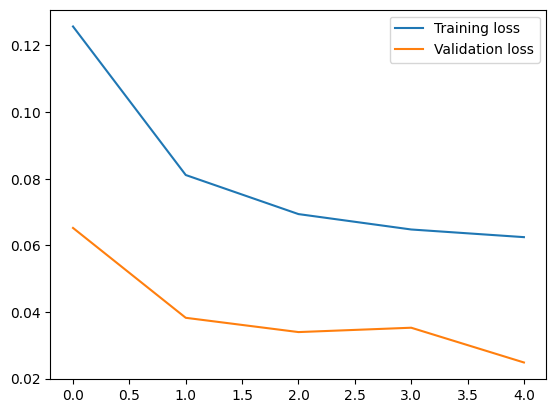

In [32]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [79]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 30
n_days_for_prediction=40  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2023-07-10 00:00:00'), Timestamp('2023-07-11 00:00:00'), Timestamp('2023-07-12 00:00:00'), Timestamp('2023-07-13 00:00:00'), Timestamp('2023-07-14 00:00:00'), Timestamp('2023-07-17 00:00:00'), Timestamp('2023-07-18 00:00:00'), Timestamp('2023-07-19 00:00:00'), Timestamp('2023-07-20 00:00:00'), Timestamp('2023-07-21 00:00:00'), Timestamp('2023-07-24 00:00:00'), Timestamp('2023-07-25 00:00:00'), Timestamp('2023-07-26 00:00:00'), Timestamp('2023-07-27 00:00:00'), Timestamp('2023-07-28 00:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-01 00:00:00'), Timestamp('2023-08-02 00:00:00'), Timestamp('2023-08-03 00:00:00'), Timestamp('2023-08-04 00:00:00'), Timestamp('2023-08-07 00:00:00'), Timestamp('2023-08-08 00:00:00'), Timestamp('2023-08-09 00:00:00'), Timestamp('2023-08-10 00:00:00'), Timestamp('2023-08-11 00:00:00'), Timestamp('2023-08-14 00:00:00'), Timestamp('2023-08-15 00:00:00'), Timestamp('2023-08-16 00:00:00'), Timestamp('2023-08-17 00:00:00'), Timestamp('20

In [80]:
#make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

2/2 [==============================] - 0s 3ms/step


In [81]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [82]:
y_pred_future

array([28.998915, 29.184069, 29.233551, 29.178326, 29.087355, 29.323166,
       29.195707, 29.125816, 28.968454, 29.142603, 29.329275, 29.508282,
       29.466484, 29.168886, 28.909023, 28.770885, 28.752777, 28.81528 ,
       28.737436, 28.602692, 28.620651, 28.507803, 28.533371, 28.792585,
       28.754385, 28.92879 , 27.78128 , 27.688852, 28.026142, 27.72033 ,
       27.564447, 27.380728, 27.218979, 27.155489, 27.12629 , 27.10308 ,
       27.041607, 26.976562, 27.034286, 26.988838], dtype=float32)

In [85]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'time':np.array(forecast_dates), 'temperature_2m_mean':y_pred_future})
df_forecast['time']=pd.to_datetime(df_forecast['time'])

C:\Users\user\AppData\Local\Temp\ipykernel_1656\3608067068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['time']=pd.to_datetime(original['time'])


<Axes: xlabel='time', ylabel='temperature_2m_mean'>

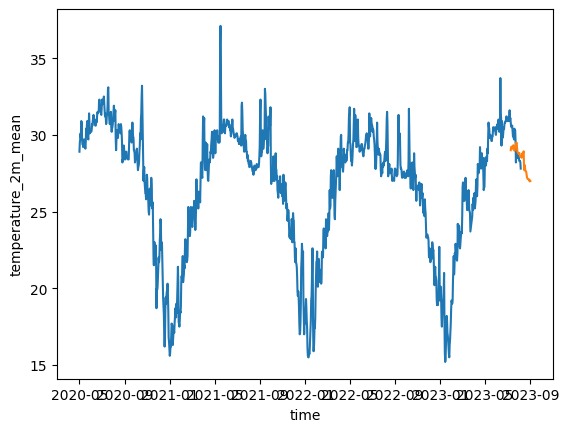

In [87]:
original = df[['time', 'temperature_2m_mean']]
original['time']=pd.to_datetime(original['time'])
original = original.loc[original['time'] >= '2020-5-1']

# sns.lineplot(original['time'], original['temperature_2m_min'])
# sns.lineplot(df_forecast['time'], df_forecast['temperature_2m_min'])

sns.lineplot(original, x="time", y="temperature_2m_mean")
sns.lineplot(df_forecast, x="time", y="temperature_2m_mean")